#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from datetime import datetime, timedelta
import pytz

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [ ]:
import tensorflow as tf

#Data Loading

In [ ]:
df = pd.read_csv('/content/drive/My Drive/aws_data/merged_data.csv')
test_df = pd.read_csv('/content/drive/My Drive/aws_data/test_data.csv')

In [ ]:
df.head()

,DATE(YYYY-MM-DD),TIME (UTC),RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm)
0,29-08-2023,07:45:00,0.0,34.0,NaN,NaN,54,268,4,8,1004.3,1027.6
1,29-08-2023,08:00:00,0.0,33.7,NaN,NaN,55,303,3,9,1004.0,1027.4
2,29-08-2023,08:15:00,0.0,33.7,NaN,NaN,51,320,4,10,1004.0,1027.4
3,29-08-2023,08:30:00,0.0,33.6,NaN,NaN,51,327,2,7,1003.9,1027.3
4,29-08-2023,08:45:00,0.0,33.5,NaN,NaN,51,13,3,7,1003.5,1026.9


In [ ]:
df['DATETIME_UTC'] = pd.to_datetime(df['DATE(YYYY-MM-DD)'] + ' ' + df['TIME (UTC)'], format='%d-%m-%Y %H:%M:%S', utc=True)

ist = pytz.timezone('Asia/Kolkata')
df['DATETIME_IST'] = df['DATETIME_UTC'].dt.tz_convert(ist)

df['DATE'] = df['DATETIME_IST'].dt.strftime('%d-%m-%Y')
df['TIME'] = df['DATETIME_IST'].dt.strftime('%H:%M:%S')

df = df.drop(['DATETIME_UTC', 'DATETIME_IST', 'DATE(YYYY-MM-DD)', 'TIME (UTC)'], axis=1)

In [ ]:
df.head()

,RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm),DATE,TIME
0,0.0,34.0,NaN,NaN,54,268,4,8,1004.3,1027.6,29-08-2023,13:15:00
1,0.0,33.7,NaN,NaN,55,303,3,9,1004.0,1027.4,29-08-2023,13:30:00
2,0.0,33.7,NaN,NaN,51,320,4,10,1004.0,1027.4,29-08-2023,13:45:00
3,0.0,33.6,NaN,NaN,51,327,2,7,1003.9,1027.3,29-08-2023,14:00:00
4,0.0,33.5,NaN,NaN,51,13,3,7,1003.5,1026.9,29-08-2023,14:15:00


In [ ]:
test_df['DATETIME_UTC'] = pd.to_datetime(test_df['DATE(YYYY-MM-DD)'] + ' ' + test_df['TIME (UTC)'], format='%d-%m-%Y %H:%M:%S', utc=True)

ist = pytz.timezone('Asia/Kolkata')
test_df['DATETIME_IST'] = test_df['DATETIME_UTC'].dt.tz_convert(ist)

test_df['DATE'] = test_df['DATETIME_IST'].dt.strftime('%d-%m-%Y')
test_df['TIME'] = test_df['DATETIME_IST'].dt.strftime('%H:%M:%S')

test_df = test_df.drop(['DATETIME_UTC', 'DATETIME_IST', 'DATE(YYYY-MM-DD)', 'TIME (UTC)'], axis=1)

In [ ]:
test_df.head()

,RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm),DATE,TIME
0,0,25.4,NaN,NaN,89,282,1,2,1008.6,1009.3,08-12-2023,05:30:00
1,0,25.4,NaN,NaN,89,294,1,4,1008.8,1009.5,08-12-2023,05:45:00
2,0,25.5,NaN,NaN,88,288,1,5,1008.9,1009.6,08-12-2023,06:00:00
3,0,25.5,NaN,NaN,90,304,2,6,1009.0,1009.7,08-12-2023,06:15:00
4,0,25.4,NaN,NaN,90,325,1,4,1009.3,1010.0,08-12-2023,06:30:00


#Preprocessing

In [ ]:
df.dtypes

RAIN FALL CUM. SINCE 0300 UTC (mm)    float64
TEMP. ('C)                            float64
TEMP DAY MIN. ('C)                    float64
TEMP DAY MAX. ('C)                    float64
RH (%)                                  int64
WIND DIR 10 m (Deg)                     int64
WIND SPEED 10 m (Kt)                    int64
WIND SPEED MAX / GUST 10 m (Kt)         int64
SLP (hPa)                             float64
MSLP (hPa / gpm)                      float64
DATE                                   object
TIME                                   object
dtype: object

In [ ]:
columns_with_nan = df.columns[df.isna().any()].tolist()
columns_with_nan

["TEMP DAY MIN. ('C)", "TEMP DAY MAX. ('C)"]

In [ ]:
df_filled_mean = df.fillna(df.mean())

<ipython-input-13-046bb2e860e0>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_filled_mean = df.fillna(df.mean())


In [ ]:
df_filled_mean.head()

,RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm),DATE,TIME
0,0.0,34.0,25.237313,33.247945,54,268,4,8,1004.3,1027.6,29-08-2023,13:15:00
1,0.0,33.7,25.237313,33.247945,55,303,3,9,1004.0,1027.4,29-08-2023,13:30:00
2,0.0,33.7,25.237313,33.247945,51,320,4,10,1004.0,1027.4,29-08-2023,13:45:00
3,0.0,33.6,25.237313,33.247945,51,327,2,7,1003.9,1027.3,29-08-2023,14:00:00
4,0.0,33.5,25.237313,33.247945,51,13,3,7,1003.5,1026.9,29-08-2023,14:15:00


In [ ]:
test_df_filled_mean = test_df.fillna(test_df.mean())

<ipython-input-14-7a7398c00bc3>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test_df_filled_mean = test_df.fillna(test_df.mean())


In [ ]:
scaler = StandardScaler()

In [ ]:
df1 = df_filled_mean.iloc[:, 0:10]

In [ ]:
X_scaled = scaler.fit_transform(df1)
df1 = pd.DataFrame(X_scaled, columns=df1.columns)

In [ ]:
df2 = test_df_filled_mean.iloc[:, 0:10]
X_scaled = scaler.fit_transform(df2)
df2 = pd.DataFrame(X_scaled, columns=df2.columns)

In [ ]:
columns_to_drop1 = df.columns[0:10]
df = df.drop(columns=columns_to_drop1)

columns_to_drop2 = test_df.columns[0:10]
test_df = test_df.drop(columns=columns_to_drop2)

In [ ]:
df = pd.merge(df, df1, left_index=True, right_index=True, how='inner')

In [ ]:
test_df = pd.merge(test_df, df2, left_index=True, right_index=True, how='inner')

In [ ]:
df.head()

,DATE,TIME,RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm)
0,29-08-2023,13:15:00,-0.316585,1.935063,-1.005859e-13,-5.921870e-14,-1.895194,0.879042,0.813748,0.196828,-0.825441,3.757570
1,29-08-2023,13:30:00,-0.316585,1.831229,-1.005859e-13,-5.921870e-14,-1.812611,1.263538,0.199547,0.457940,-0.926624,3.718489
2,29-08-2023,13:45:00,-0.316585,1.831229,-1.005859e-13,-5.921870e-14,-2.142946,1.450293,0.813748,0.719052,-0.926624,3.718489
3,29-08-2023,14:00:00,-0.316585,1.796617,-1.005859e-13,-5.921870e-14,-2.142946,1.527192,-0.414653,-0.064284,-0.960351,3.698948
4,29-08-2023,14:15:00,-0.316585,1.762006,-1.005859e-13,-5.921870e-14,-2.142946,-1.922282,0.199547,-0.064284,-1.095262,3.620787


In [ ]:
df

,DATE,TIME,RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm)
0,29-08-2023,13:15:00,-0.316585,1.935063,-1.005859e-13,-5.921870e-14,-1.895194,0.879042,0.813748,0.196828,-0.825441,3.757570
1,29-08-2023,13:30:00,-0.316585,1.831229,-1.005859e-13,-5.921870e-14,-1.812611,1.263538,0.199547,0.457940,-0.926624,3.718489
2,29-08-2023,13:45:00,-0.316585,1.831229,-1.005859e-13,-5.921870e-14,-2.142946,1.450293,0.813748,0.719052,-0.926624,3.718489
3,29-08-2023,14:00:00,-0.316585,1.796617,-1.005859e-13,-5.921870e-14,-2.142946,1.527192,-0.414653,-0.064284,-0.960351,3.698948
4,29-08-2023,14:15:00,-0.316585,1.762006,-1.005859e-13,-5.921870e-14,-2.142946,-1.922282,0.199547,-0.064284,-1.095262,3.620787
...,...,...,...,...,...,...,...,...,...,...,...,...
7022,07-12-2023,04:15:00,-0.316585,-0.903067,-1.005859e-13,-5.921870e-14,1.242986,0.955941,-1.643055,-1.630957,0.085205,-0.130977
7023,07-12-2023,04:30:00,-0.316585,-0.868455,-1.005859e-13,-5.921870e-14,1.242986,0.890028,-1.028854,-1.369845,0.118932,-0.111436
7024,07-12-2023,04:45:00,-0.316585,-0.868455,-1.005859e-13,-5.921870e-14,1.242986,0.549475,-1.643055,-1.630957,0.085205,-0.130977
7025,07-12-2023,05:00:00,-0.316585,-0.903067,-1.005859e-13,-5.921870e-14,1.242986,0.736230,-1.028854,-1.630957,0.118932,-0.111436


In [ ]:
test_df

,DATE,TIME,RAIN FALL CUM. SINCE 0300 UTC (mm),TEMP. ('C),TEMP DAY MIN. ('C),TEMP DAY MAX. ('C),RH (%),WIND DIR 10 m (Deg),WIND SPEED 10 m (Kt),WIND SPEED MAX / GUST 10 m (Kt),SLP (hPa),MSLP (hPa / gpm)
0,08-12-2023,05:30:00,0.0,-0.610215,3.787294e-14,5.462150e-14,1.346592,1.089484,-0.69688,-1.471225,-1.163680,-1.163680
1,08-12-2023,05:45:00,0.0,-0.610215,3.787294e-14,5.462150e-14,1.346592,1.175700,-0.69688,-0.920048,-1.015821,-1.015821
2,08-12-2023,06:00:00,0.0,-0.554150,3.787294e-14,5.462150e-14,1.240871,1.132592,-0.69688,-0.644460,-0.941891,-0.941891
3,08-12-2023,06:15:00,0.0,-0.554150,3.787294e-14,5.462150e-14,1.452313,1.247547,-0.26334,-0.368871,-0.867961,-0.867961
4,08-12-2023,06:30:00,0.0,-0.610215,3.787294e-14,5.462150e-14,1.452313,1.398426,-0.69688,-0.920048,-0.646172,-0.646172
...,...,...,...,...,...,...,...,...,...,...,...,...
642,15-12-2023,04:15:00,0.0,-0.890540,3.787294e-14,5.462150e-14,0.500826,1.111038,-0.69688,-1.195637,0.167056,0.167056
643,15-12-2023,04:30:00,0.0,-0.890540,3.787294e-14,5.462150e-14,0.606546,1.362502,-0.69688,-0.920048,0.167056,0.167056
644,15-12-2023,04:45:00,0.0,-0.946604,3.787294e-14,5.462150e-14,0.500826,1.542119,-0.69688,-0.093283,0.240986,0.240986
645,15-12-2023,05:00:00,0.0,-0.890540,3.787294e-14,5.462150e-14,0.606546,1.261917,-0.69688,-0.644460,0.388846,0.388846


#Training

SARIMA

In [ ]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
df = df.to_numpy()

In [ ]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

df1 = np.asarray(df1)
df1 = df1[:, 0]

model = SARIMAX(df1, order=order, seasonal_order=seasonal_order)
results = model.fit()

In [ ]:
forecast_steps = len(df2)
predictions = results.get_forecast(steps=forecast_steps)

In [ ]:
df2 = np.asarray(df2)
df2 = df2[:, 0]

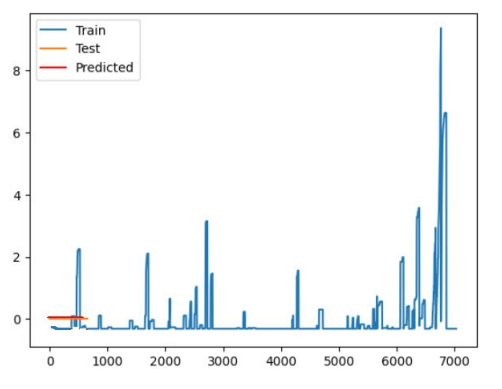

In [ ]:
plt.plot(df1, label='Train')
plt.plot(df2, label='Test')
plt.plot(predictions.predicted_mean, label='Predicted', color='red')
plt.legend()
plt.show()

CNN

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(df.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(tf.convert_to_tensor(df), df, epochs=100, batch_size=32)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.models import Sequential, Model
from keras.applications.xception import Xception

def SARIMA_Xception_LSTM(input_shape=(12, 10)):
  base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
  base_model.trainable = False

  x = base_model.output
  x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)
  x = Conv2D(1024, (3, 3), padding='same', activation='relu')(x)
  x = MaxPooling2D((2, 2))(x)
  x = Dropout(0.2)(x)
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(1)(x)

  model = Model(inputs=base_model.input, outputs=x)
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [ ]:
model_history = model.fit(SARIMA_Xception_LSTM(), epochs = 50, batch_size = 2 ,
                                             shuffle = True, validation_split = 0.1, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
35/35 [==============================] - 29s 632ms/step - loss: 0.6531 - accuracy: 0.6364
Epoch 2/50
35/35 [==============================] - 20s 572ms/step - loss: 0.6380 - accuracy: 0.6764
Epoch 3/50
35/35 [==============================] - 21s 602ms/step - loss: 0.6286 - accuracy: 0.6873
Epoch 4/50
35/35 [==============================] - 20s 580ms/step - loss: 0.6131 - accuracy: 0.6873
Epoch 5/50
35/35 [==============================] - 20s 568ms/step - loss: 0.5731 - accuracy: 0.6836
Epoch 6/50
35/35 [==============================] - 20s 569ms/step - loss: 0.5640 - accuracy: 0.6836
Epoch 7/50
35/35 [==============================] - 20s 573ms/step - loss: 0.5511 - accuracy: 0.6836
Epoch 8/50
35/35 [==============================] - 21s 604ms/step - loss: 0.5006 - accuracy: 0.6909
Epoch 9/50
35/35 [==============================] - 20s 577ms/step - loss: 0.4705 - accuracy: 0.7382
Epoch 10/50
35/35 [==============================] - 20s 575ms/step - loss: 0.4273 - accura

In [ ]:
loss, accuracy = model.evaluate(test_images, test_masks)

35/35 [==============================] - 0s 982ms/step - loss: 0.3094 - accuracy: 0.9728


In [ ]:
preds = model_history.predict(df2)
preds = scaler.inverse_transform(preds)
print(preds.shape)

(647, 1)


In [ ]:
rmse_error = mean_squared_error(actuals, preds)
print(rmse_error)

0.0003958811954194622
